---
# Exercise


1 - create the geodataframe of the [libraries](https://opendata.anagrafe.iccu.sbn.it/territorio.zip) of Italy (data from the italian [Ministry of Culture](https://anagrafe.iccu.sbn.it/it/open-data/)) and count the total of the libraries for each muncipality of Piedmont

2 - identify the difference of municipalities in Piedmont in the year [2022](https://github.com/napo/geospatial_unitn_2024/raw/refs/heads/main/data/municipalities_piedmont_2022.parquet) with the year [2024](https://github.com/napo/geospatial_unitn_2024/raw/refs/heads/main/data/municipalities_piedmont_2024.parquet)
  - identify which municipalities are created from aggregation to others
  - find the new municipality with the largest extension in Piedmont and show all the italian municipalities with bordering it
  - create the macroarea of all the municipalities bordering with it
  - for each library in the macro-area, calculate how many monumental trees have been within a 500m radius
  
3 - create a polygon that contains all the monumental trees inside the area
  - identify all the libraries in this area which are within 2km of each other
  - save the polygon in geopackage with the attribute "description" with the name of the library

4 - create the polygon of the Island of Elba from the layer of municipalities with functions of overlay

---

# Solutions

## learning objectives
* repeat the concepts on the previous lesson
* spatial sql
* errors with the simplified boundaries
* convex hull / concave hull / alphashape
* nearest_points


## Setup

In [1]:
pip install -r https://napo.github.io/geospatial_unitn_2024/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 1.3 MB/s eta 0:00:00


---

### Import of the packages

In [18]:
import requests
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import warnings
warnings.simplefilter("ignore")
pd.options.mode.chained_assignment = None

# 1 - create the geodataframe of the [libraries](https://opendata.anagrafe.iccu.sbn.it/territorio.zip) of Italy

In [3]:
urlfile = "https://opendata.anagrafe.iccu.sbn.it/territorio.zip"

In [4]:
libraries = pd.read_csv(urlfile, sep=";")

In [5]:
libraries.head(5)

,codice-isil,codice-sbn,denominazione,indirizzo,frazione,cap,comune,codice istat comune,provincia,regione,codice istat provincia,latitudine,longitudine,telefono,fax,email,url
0,IT-AG0001,AGR27,Biblioteca della Soprintendenza per i beni cul...,Contrada S. Nicola,NaN,92100,Agrigento,84001,Agrigento,SICILIA,84,"37,3361677","13,5880717",+39 0922595830,NaN,NaN,NaN
1,IT-AG0005,NaN,Biblioteca dell'Archivio di Stato di Agrigento,via Mazzini 185,NaN,92100,Agrigento,84001,Agrigento,SICILIA,84,"37,3221644312329","13,5886026454773",+39 0922602494,+39 0922613242,as-ag@cultura.gov.it,http://www.archiviodistatoagrigento.benicultur...
2,IT-AG0006,PBED8,Biblioteca del Seminario vescovile,Piazza don Minzoni,NaN,92100,Agrigento,84001,Agrigento,SICILIA,84,"37,3137125","13,5749656",+39 3478809439,+39 0922.490024,bibliotecadiocesana@diocesiag.it,NaN
3,IT-AG0007,AGR01,Biblioteca Comunale Franco La Rocca,Piazzale Aldo Moro 3,NaN,92100,Agrigento,84001,Agrigento,SICILIA,84,"37,3095818","13,586151",+39 0922595166,+39 0922401246,biblioteca.larocca@comune.agrigento.it,http://www.opacagrigento.it/biblioteche/bi_1.html
4,IT-AG0008,NaN,Biblioteca comunale F. La Rocca - Sezione este...,Via Belvedere 127,Giardina Gallotti,92100,Agrigento,84001,Agrigento,SICILIA,84,"37,4050904","13,5291051",+39 0922410117,NaN,NaN,NaN


In [6]:
libraries.columns

Index(['codice-isil', 'codice-sbn', 'denominazione', 'indirizzo', 'frazione',
       'cap', 'comune', 'codice istat comune', 'provincia', 'regione',
       'codice istat provincia', 'latitudine', 'longitudine', 'telefono',
       'fax', 'email', 'url'],
      dtype='object')

In [9]:
columns = {
    'codice-isil': 'isil',
    'codice-sbn': 'sbn',
    'denominazione': 'name',
    'indirizzo':'address',
    'frazione':'village',
    'cap':'zipcode',
    'comune':'city',
    'codice istat comune': 'istat_city',
    'provincia':'province',
    'regione': 'region',
    'codice istat provincia': 'istat_province',
    'latitudine':'latitude',
    'longitudine':'longitude',
    'telefono':'phone'
}

In [10]:
libraries.rename(columns=columns,inplace=True)

In [14]:
libraries.head(3)

,isil,sbn,name,address,village,zipcode,city,istat_city,province,region,istat_province,latitude,longitude,phone,fax,email,url
0,IT-AG0001,AGR27,Biblioteca della Soprintendenza per i beni cul...,Contrada S. Nicola,NaN,92100,Agrigento,84001,Agrigento,SICILIA,84,"37,3361677","13,5880717",+39 0922595830,NaN,NaN,NaN
1,IT-AG0005,NaN,Biblioteca dell'Archivio di Stato di Agrigento,via Mazzini 185,NaN,92100,Agrigento,84001,Agrigento,SICILIA,84,"37,3221644312329","13,5886026454773",+39 0922602494,+39 0922613242,as-ag@cultura.gov.it,http://www.archiviodistatoagrigento.benicultur...
2,IT-AG0006,PBED8,Biblioteca del Seminario vescovile,Piazza don Minzoni,NaN,92100,Agrigento,84001,Agrigento,SICILIA,84,"37,3137125","13,5749656",+39 3478809439,+39 0922.490024,bibliotecadiocesana@diocesiag.it,NaN


In [17]:
libraries['latitude'] = libraries['latitude'].str.replace(",",".").astype(float)
libraries['longitude'] = libraries['longitude'].str.replace(",",".").astype(float)

## create the geodataframe

In [19]:
geo_libraries = gpd.GeoDataFrame(
    libraries,
    crs='EPSG:4326',
    geometry=gpd.points_from_xy(libraries.longitude, libraries.latitude))

In [20]:
geo_libraries[geo_libraries.geometry.is_empty].shape[0]

15

Error:<br/>
the values should be zero: the geodataframe should contains points.<br/>
Maybe therea are some rows where the values of latitude and lontigude aren't present

In [21]:
geo_libraries.latitude.isnull().sum()

15

In [22]:
geo_libraries.longitude.isnull().sum()

15

3 ... the same value for the invalid geometries

In [23]:
libraries = libraries[~libraries.latitude.isnull()]

In [24]:
geo_libraries = gpd.GeoDataFrame(
    libraries,
    crs='EPSG:4326',
    geometry=gpd.points_from_xy(libraries.longitude, libraries.latitude))

In [25]:
geo_libraries[geo_libraries.geometry.is_empty].shape[0]

0

Now it's ZERO :)

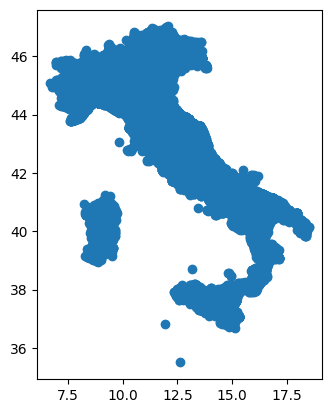

In [26]:
geo_libraries.plot()
plt.show()

## count the total of the libraries for each muncipality of Lombardia

we need the data of the municipalities of Piedmont

here is provided as parquet format

https://github.com/napo/geospatial_unitn_2024/raw/refs/heads/main/data/municipalities_piedmont_2024.parquet

### load the data

In [42]:
url2024 = 'https://github.com/napo/geospatial_unitn_2024/raw/refs/heads/main/data/municipalities_piedmont_2024.parquet'
municipalities2024 = pd.read_parquet(url2024)

In [43]:
municipalities2024.head(3)

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,geometry
0,1,1,1,0,201,1001,001001,Agliè,0,0,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xfa\x02...
1,1,1,1,0,201,1002,001002,Airasca,0,0,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x93\x02...
2,1,1,1,0,201,1003,001003,Ala di Stura,0,0,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00T\x03\x0...


In [44]:
municipalities2024.geometry[0]

b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xfa\x02\x00\x00\x8c\x08\xa9\x07r!\x1f@\xa8+\xc0\xe6\x8e\xb1F@\tK.\xac\xd6!\x1f@\x97\xb3\x13\xdb\x8d\xb1F@\xba?\xa4\x01;"\x1f@Y\x8a`\x94\x8e\xb1F@Ld\xf2\xe2\xa5"\x1f@\xe6\xb8E2\x90\xb1F@\x90\x96\xb2\xd8\xe8"\x1f@\xb6p\x16I\x90\xb1F@\x9cQN_\x0f#\x1f@/\x8c\x86\xcb\x8f\xb1F@~\x8d\xfc\xbe<#\x1f@`\xf9\xa57\x8f\xb1F@j\x8b\xb64\x80#\x1f@\xf7]\x85[\x8c\xb1F@\xa9@\xa8\x96\xa5#\x1f@\xedY\xad)\x89\xb1F@r\xdb\x84^\xd5#\x1f@x\xa9\xcd\xea\x83\xb1F@\xe9\x8d\xcf\xe6\xfd#\x1f@\xdf\\\n\xe8\x81\xb1F@\xb5\xc7\x1d\xac)$\x1f@\t\xa0v}\x80\xb1F@\xf0A\x86\'\xa6$\x1f@\xa0\xd3\x9c\x1d}\xb1F@\xb7=\x8dOD%\x1f@<\xc9Y\x9bx\xb1F@\x08\x08\x98V\x18&\x1f@\xf3\x9dKfr\xb1F@\xa7\x8b7\xbde&\x1f@7mi$p\xb1F@\n\xcc\x96\xc8\xca&\x1f@\x1f\xeb\xb0\xbcl\xb1F@]t\xa1\x8d\xf6&\x1f@{m\x16Rk\xb1F@^\x9d\xec\xa1"\'\x1f@\xfb\xe0P"h\xb1F@q\x18\x8b\x83=\'\x1f@\x8d\x16\x84\x94g\xb1F@LD\x8d\xde\x83\'\x1f@?\xb0\xef`g\xb1F@\x13\xd02B\xe8\'\x1f@3Ix\xceg\xb1F@s\x1b|\x9b1(\x1f@2\x1bv\xaci\xb1F@\xfa\\j%\x88(\x1

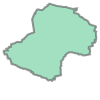

In [45]:
from shapely import from_wkb
from_wkb(municipalities2024.geometry[0])

In [46]:
from_wkb(municipalities2024.geometry[0]).wkt

'POLYGON ((7.782661552135448 45.387173503716724, 7.7830454734091825 45.38714159452427, 7.783428216600379 45.38716368402374, 7.783835931820317 45.387213024181435, 7.7840913638116405 45.387215743977706, 7.784238328128051 45.38720077581126, 7.7844114152570665 45.38718314747052, 7.7846687542358755 45.38709587108672, 7.784811357516596 45.38699837650697, 7.784993626460038 45.386838293476956, 7.78514824525653 45.386776928958845, 7.785315217321046 45.38673370640033, 7.785790078706199 45.386630727363126, 7.786393397327109 45.38649312862478, 7.787202218083628 45.38630369846569, 7.787497478976468 45.38623480937752, 7.787882932857437 45.386130892168005, 7.788049900988963 45.38608766646481, 7.788218050066773 45.385990418902985, 7.788320594181742 45.38597351503004, 7.788588979122391 45.38596736625231, 7.788971933699957 45.385980423673026, 7.789251737069992 45.38603740469843, 7.789581856362242 45.386130900284535, 7.789785245388353 45.386178073248836, 7.79020591231349 45.386218533775164, 7.79062677301

In [47]:
geo_municipalities2024 = gpd.GeoDataFrame(
    municipalities2024,
    crs="epsg:4326",
    geometry=municipalities2024['geometry'].apply(lambda x:from_wkb(x))
)

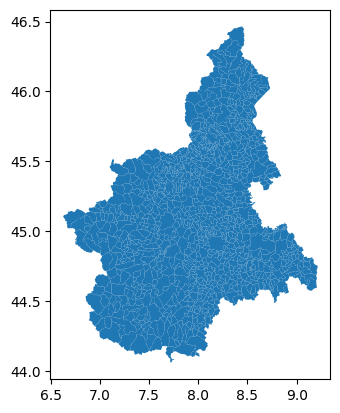

In [48]:
geo_municipalities2024.plot()
plt.show()

### count the points

In [49]:
libraries_municipalities_piedmont = geo_libraries.sjoin(geo_municipalities2024.to_crs(epsg=4326),predicate="within")

[]

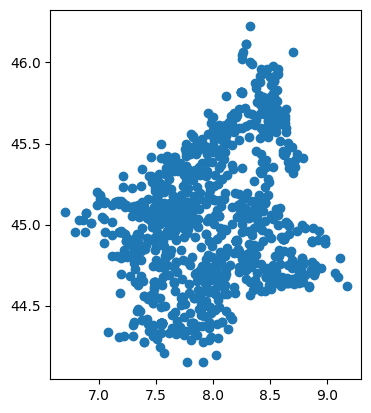

In [50]:
libraries_municipalities_piedmont.plot()
plt.plot()

In [51]:

libraries_municipalities_piedmont.region.unique()

array(['PIEMONTE'], dtype=object)

In [52]:
libraries_municipalities_piedmont.province.unique()

array(['Alessandria', 'Asti', 'Biella', 'Cuneo', 'Novara', 'Torino',
       'Verbano-Cusio-Ossola', 'Vercelli'], dtype=object)

In [53]:
libraries_municipalities_piedmont.COMUNE.value_counts()

,count
COMUNE,
Torino,230
Biella,23
Novara,22
Cuneo,20
Alessandria,17
...,...
Santo Stefano Belbo,1
Sinio,1
Sommariva del Bosco,1


# 2 - identify the difference of municipalities in Lombardia in the year [2022](https://github.com/napo/geospatial_unitn_2024/raw/refs/heads/main/data/municipalities_piedmont_2022.parquet) with the year [2024](https://github.com/napo/geospatial_unitn_2024/raw/refs/heads/main/data/municipalities_piedmont_2024.parquet)


there is the way of geopandas for the geoparquet format

In [54]:
url2022 = 'https://github.com/napo/geospatial_unitn_2024/raw/refs/heads/main/data/municipalities_piedmont_2022.parquet'
municipalities2022 = pd.read_parquet(url2022)

... or ... you can simple download the file and open it with the methodo .read_parquet() for the GeoDataFrame

In [56]:
# download the file
geo_municipalities2022_file = "municipalities_piedmont_2022.parquet"
r = requests.get(url2022, allow_redirects=True)
open(geo_municipalities2022_file, 'wb').write(r.content)

15044743

In [57]:
geo_municipalities2022 = gpd.read_parquet(geo_municipalities2022_file)

In [58]:
geo_municipalities2022.head(3)

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,geometry
0,1,1,1,201,201,1001,001001,Agliè,0,0,"POLYGON ((7.78266 45.38717, 7.78305 45.38714, ..."
1,1,1,1,201,201,1002,001002,Airasca,0,0,"POLYGON ((7.48795 44.93917, 7.48798 44.93874, ..."
2,1,1,1,201,201,1003,001003,Ala di Stura,0,0,"POLYGON ((7.27324 45.33927, 7.27344 45.33907, ..."


In [59]:
geo_municipalities2022.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

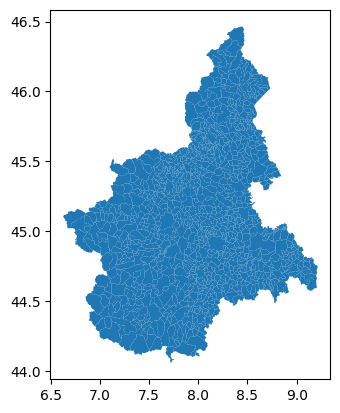

In [60]:
geo_municipalities2022.plot()
plt.show()

and now we are ready to solve the issue

In [61]:
geo_municipalities2022.shape[0]-geo_municipalities2024.shape[0]

1

In [62]:
ids_municipalities2022 = set(list(geo_municipalities2022.PRO_COM_T.unique()))-set(list(geo_municipalities2024.PRO_COM_T.unique()))

In [63]:
ids_municipalities2022

{'005079', '005110'}

In [64]:
old_municipalities_2022 = geo_municipalities2022[geo_municipalities2022.PRO_COM_T.isin(ids_municipalities2022)]

In [65]:
old_municipalities_2022

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,geometry
411,1,1,5,0,5,5079,005079,Moransengo,0,0,"POLYGON ((8.02884 45.13272, 8.02895 45.1327, 8..."
834,1,1,5,0,5,5110,005110,Tonengo,0,0,"POLYGON ((7.99235 45.12831, 7.99254 45.1283, 7..."


[]

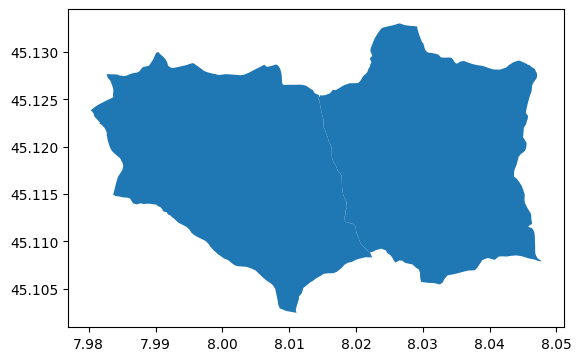

In [66]:
old_municipalities_2022.plot()
plt.plot()

In [67]:
ids_municipalities2024 = set(list(geo_municipalities2024.PRO_COM_T.unique()))-set(list(geo_municipalities2022.PRO_COM_T.unique()))

In [68]:
ids_municipalities2024

{'005122'}

In [69]:
new_municipalities2024 = geo_municipalities2024[geo_municipalities2024.PRO_COM_T.isin(ids_municipalities2024)]

In [70]:
new_municipalities2024

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,geometry
844,1,1,5,0,5,5122,005122,Moransengo-Tonengo,0,0,"POLYGON ((8.02884 45.13272, 8.02895 45.1327, 8..."


[]

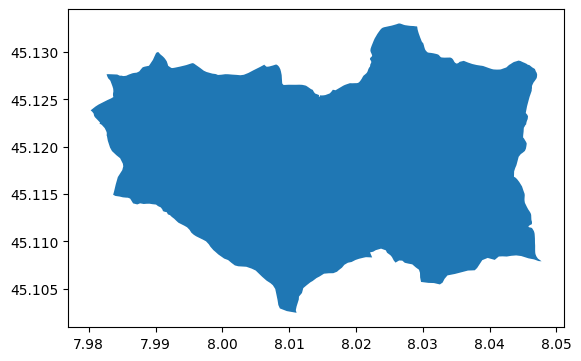

In [71]:
new_municipalities2024.plot()
plt.plot()

the spatial relationship way

In [72]:
def whereincluded(geometry, geometries_gdf):
    name = "not included"
    found = geometries_gdf[geometries_gdf.geometry.contains(geometry)]
    if len(found) > 0:
        name = found.COMUNE.values[0]
    return(name)

In [73]:
old_municipalities_2022['included_in'] = old_municipalities_2022.geometry.apply(lambda g: whereincluded(g,new_municipalities2024))

In [75]:
old_municipalities_2022[['COMUNE','included_in']]

,COMUNE,included_in
411,Moransengo,Moransengo-Tonengo
834,Tonengo,Moransengo-Tonengo


### find the biggest new municipality of Piedmont and show all the italian municipalities with bordering it

In [76]:
biggest_municipality = new_municipalities2024[new_municipalities2024.geometry.area == new_municipalities2024.geometry.area.max()]

In [77]:
boundary = biggest_municipality.geometry.values[0]

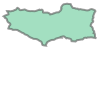

In [78]:
boundary

In [79]:
around = geo_municipalities2024[geo_municipalities2024.touches(boundary)]

In [80]:
around

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,geometry
35,1,1,1,0,201,1037,001037,Brozolo,0,0,"POLYGON ((8.09637 45.13174, 8.0961 45.13164, 8..."
37,1,1,1,0,201,1039,001039,Brusasco,0,0,"POLYGON ((8.05347 45.18457, 8.05415 45.18374, ..."
58,1,1,1,0,201,1060,001060,Casalborgone,0,0,"POLYGON ((7.91732 45.14662, 7.91742 45.14652, ..."
67,1,1,1,0,201,1069,001069,Cavagnolo,0,0,"POLYGON ((8.04048 45.16667, 8.04062 45.16636, ..."
127,1,1,1,0,201,1129,001129,Lauriano,0,0,"POLYGON ((8.00493 45.18012, 8.00495 45.17981, ..."
731,1,1,5,0,5,5004,005004,Aramengo,0,0,"POLYGON ((7.98072 45.1235, 7.98076 45.12338, 7..."
769,1,1,5,0,5,5042,005042,Cocconato,0,0,"POLYGON ((8.02538 45.10834, 8.02565 45.10797, ..."


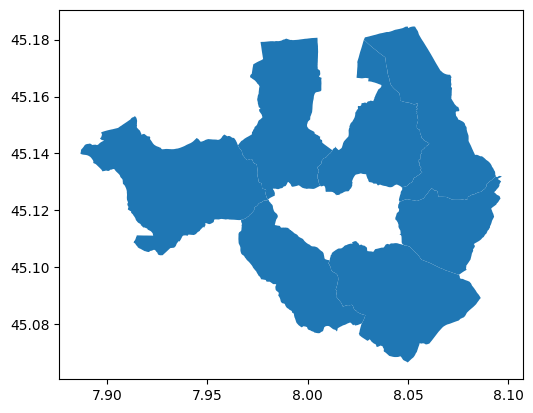

In [81]:
around.plot()
plt.show()

### create the macroarea of all the municipalities bordering with it

In [88]:
new_area = pd.concat([around,biggest_municipality], ignore_index=True).dissolve()


In [89]:
new_area

,geometry,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS
0,"POLYGON ((8.07586 45.09614, 8.07663 45.09594, ...",1,1,1,0,201,1037,001037,Brozolo,0,0


In [90]:
new_area['name'] = "macroarea"

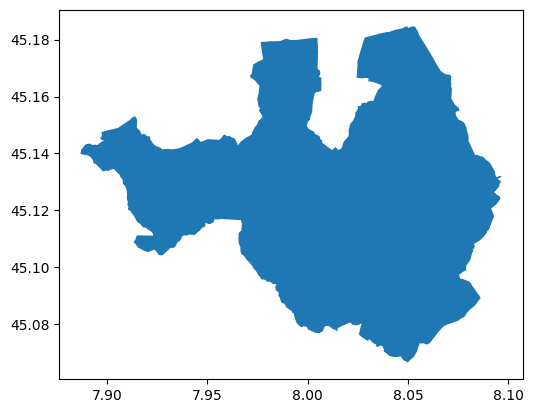

In [91]:
new_area.plot()
plt.show()

### for each library in the macro-area, calculate how many monumental trees have been within a 500m radius

the dataset in GeoJSON of the italian monumental trees is created with the [code of the previous lecture](https://github.com/napo/geospatial_unitn_2024/blob/main/code/03_spatial_relationships_and_operations.ipynb)<br/>
You can find the dataset [here](https://raw.githubusercontent.com/napo/geospatial_unitn_2024/refs/heads/main/data/geo_monumental_trees.geojson)




In [103]:
monumental_trees = gpd.read_file("https://raw.githubusercontent.com/napo/geospatial_unitn_2024/refs/heads/main/data/geo_monumental_trees.geojson")

In [104]:
cod_prov = new_area.COD_PROV.unique()[0]

In [105]:
cod_prov

1

In [118]:
area_province_turin = geo_municipalities2024[geo_municipalities2024.COD_PROV == cod_prov].dissolve().to_crs(4326).geometry[0]

In [119]:
trees_in_area = monumental_trees[monumental_trees.geometry.within(area_province_turin)]

In [120]:
trees_in_area.province.unique()

array(['Torino'], dtype=object)

In [121]:
trees500m = trees_in_area.to_crs(epsg=32632).buffer(500).to_crs(epsg=4326)

In [122]:
libraries_500m_from_trees = geo_libraries[geo_libraries.within(trees500m)].shape[0]

In [123]:
print("There are %s monumentals trees 500m from the libraries " % libraries_500m_from_trees)

There are 0 monumentals trees 500m from the libraries 


## 3 - create a polygon that contains all the monumental trees inside the province of the selected area


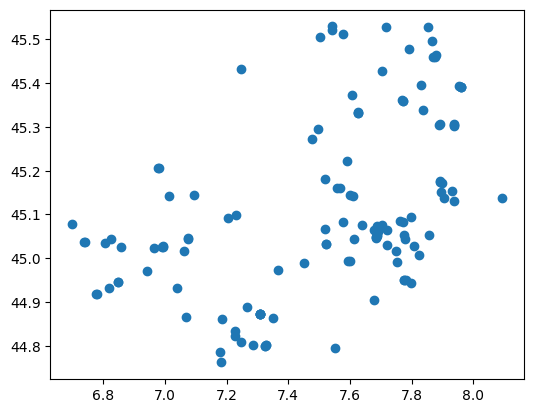

In [124]:
trees_in_area.plot()
plt.show()

In [125]:
trees_in_area.shape[0]

131

In [131]:
trees_in_area_nospatialrel = monumental_trees[monumental_trees.province == "Torino"]

In [132]:
trees_in_area_nospatialrel.shape[0]

131

the total is right ;)

### identify all the libraries in this area which are within 2km of each other

# 3 - creates a polygon that contains all the monumental trees inside the area

## convex hull
solution: create a convex hull<br/>
*In geometry, the convex hull or convex envelope or convex closure of a shape is the smallest convex set that contains it. The convex hull may be defined either as the intersection of all convex sets containing a given subset of a Euclidean space, or equivalently as the set of all convex combinations of points in the subset. For a bounded subset of the plane, the convex hull may be visualized as the shape enclosed by a rubber band stretched around the subset.* (source: [wikipedia](https://en.wikipedia.org/wiki/Convex_hull))

![](https://upload.wikimedia.org/wikipedia/commons/thumb/d/de/ConvexHull.svg/301px-ConvexHull.svg.png)

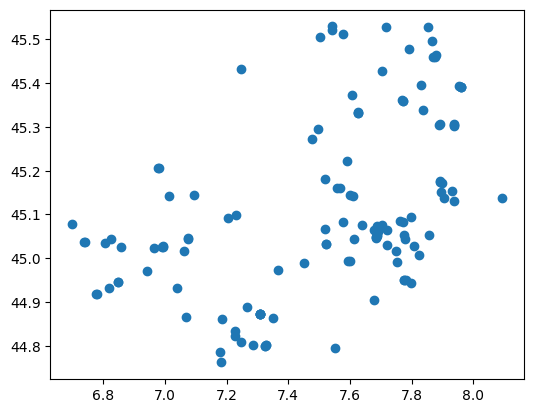

In [133]:
trees_in_area.plot()
plt.show()

In [134]:
trees_in_area_polygon = trees_in_area.unary_union.convex_hull

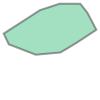

In [135]:
trees_in_area_polygon

## Concave Hull

Contrary to a convex hull, a concave hull can describe the shape of a point cloud.

Convex hull<br/>
![](https://grass.osgeo.org/grass78/manuals/addons/v_concave_convex.png)
<br/><br/>
Concave hull<br/>
![](https://grass.osgeo.org/grass78/manuals/addons/v_concave_concave.png)


### Alpha shapes

Alpha shapes are often used to generalize bounding polygons containing sets of points. The alpha parameter is defined as the value a, such that an edge of a disk of radius 1/a can be drawn between any two edge members of a set of points and still contain all the points. The convex hull, a shape resembling what you would see if you wrapped a rubber band around pegs at all the data points, is an alpha shape where the alpha parameter is equal to zero

[https://alphashape.readthedocs.io/](https://alphashape.readthedocs.io/)

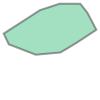

In [138]:
trees_in_area_polygon

In [139]:
import alphashape

In [140]:
alpha_shape = alphashape.alphashape(trees_in_area, 10)


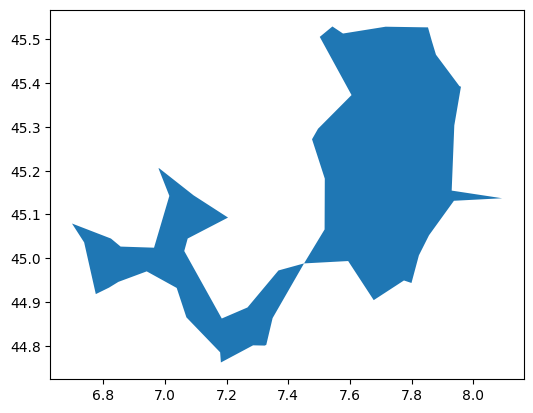

In [141]:
alpha_shape.plot()
plt.show()

... we have only three points ... but if you want try with more ...

In [142]:
convex_hull = gpd.GeoDataFrame(
    geometry=[trees_in_area_polygon],
    columns=['geometry'],
    crs=trees_in_area.crs)

convex_hull.explore()

In [143]:
trees_in_area.explore()

In [144]:
alpha_paramenter = 10
alphashape.alphashape(trees_in_area, alpha_paramenter).explore()

Creating alpha shapes around sets of points usually requires a visually interactive step where the alpha parameter for a concave hull is determined by iterating over or bisecting values to approach a best fit.

More informations: [https://alphashape.readthedocs.io/en/latest/readme.html#using-a-varying-alpha-parameter](https://alphashape.readthedocs.io/en/latest/readme.html#using-a-varying-alpha-parameter)

## identify all the libraries in Piedmont which are within 2km of each other

In [145]:
libraries_municipalities_piedmont.shape[0]

1202

## nearest points

In [146]:
from shapely.ops import nearest_points

shapely offers a method to identify the nearest points between two geometries<br/>
Documentation [here](https://shapely.readthedocs.io/en/stable/manual.html#shapely.ops.nearest_points)


In [147]:
libraries_municipalities_piedmont['nearest_id'] = ""
libraries_municipalities_piedmont['distance'] = -1
for idx, row in libraries_municipalities_piedmont.to_crs(epsg=32632).iterrows():
    isil = row['isil']
    point = row['geometry']
    multipoints = libraries_municipalities_piedmont[libraries_municipalities_piedmont.isil != isil]["geometry"].to_crs(epsg=32632).unary_union
    nearest_geoms = nearest_points(point, multipoints)
    maxdistance = 0
    nearest_id = ""
    for pn in nearest_geoms:
        dist = point.distance(pn)
        if (dist > maxdistance and dist <= 2000):
            nearest_id = libraries_municipalities_piedmont[libraries_municipalities_piedmont.to_crs(epsg=32632).geometry == pn]['isil'].values[0]
            maxdistance = dist
    libraries_municipalities_piedmont.loc[idx,"distance"] = maxdistance
    libraries_municipalities_piedmont.loc[idx,"nearest_id"] = nearest_id
%time

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [148]:
libraries_municipalities_piedmont

,isil,sbn,name,address,village,zipcode,city,istat_city,province,region,...,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,nearest_id,distance
62,IT-AL0001,TO036,"Biblioteca civica di Acqui Terme ""La Fabbrica ...",Via Maggiorino Ferraris 15,NaN,15011,Acqui Terme,6001,Alessandria,PIEMONTE,...,6,0,6,6001,006001,Acqui Terme,0,0,IT-AL0212,369.594479
63,IT-AL0002,TO041,Biblioteca civica Francesca Calvo,Piazza Vittorio Veneto 1,NaN,15121,Alessandria,6003,Alessandria,PIEMONTE,...,6,1,6,6003,006003,Alessandria,0,1,IT-AL0302,112.250185
64,IT-AL0003,TO0X1,Biblioteca dell'Archivio di Stato di Alessandria,Via Giorgio Solero 43,NaN,15121,Alessandria,6003,Alessandria,PIEMONTE,...,6,1,6,6003,006003,Alessandria,0,1,IT-AL0310,408.102627
65,IT-AL0004,TO0GQ,Biblioteca diocesana del Seminario vescovile,"Via Inviziati, 1",NaN,15121,Alessandria,6003,Alessandria,PIEMONTE,...,6,1,6,6003,006003,Alessandria,0,1,IT-AL0007,238.228119
66,IT-AL0006,NaN,"Biblioteca delle Societa' di storia, arte e ar...",Via Plana 42,NaN,15100,Alessandria,6003,Alessandria,PIEMONTE,...,6,1,6,6003,006003,Alessandria,0,1,IT-AL0318,136.759111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12999,IT-VC0186,TO0AF,"Biblioteca ""Fernanda Jona""",Via Duomo 4,NaN,13100,Vercelli,2158,Vercelli,PIEMONTE,...,2,1,2,2158,002158,Vercelli,0,1,IT-VC0120,172.998352
13000,IT-VC0187,TO0AG,Biblioteca Notaio Giuseppe Torelli,Via Galileo Ferraris 52,NaN,13100,Vercelli,2158,Vercelli,PIEMONTE,...,2,1,2,2158,002158,Vercelli,0,1,IT-VC0133,32.632669
13001,IT-VC0188,NaN,Biblioteca comunale di Scopa,Piazza Municipio 1,NaN,13027,Scopa,2134,Vercelli,PIEMONTE,...,2,0,2,2134,002134,Scopa,0,0,,0.000000
13003,IT-VC0190,NaN,Biblioteca sociale PuntoLibro don Pietro Gauzo...,"Via Giuseppe Nicolello, 2",S. Antonino,13040,Saluggia,2128,Vercelli,PIEMONTE,...,2,0,2,2128,002128,Saluggia,0,0,,0.000000


In [150]:
libraries_municipalities_piedmont[['isil','name','city','nearest_id','distance']]

,isil,name,city,nearest_id,distance
62,IT-AL0001,"Biblioteca civica di Acqui Terme ""La Fabbrica ...",Acqui Terme,IT-AL0212,369.594479
63,IT-AL0002,Biblioteca civica Francesca Calvo,Alessandria,IT-AL0302,112.250185
64,IT-AL0003,Biblioteca dell'Archivio di Stato di Alessandria,Alessandria,IT-AL0310,408.102627
65,IT-AL0004,Biblioteca diocesana del Seminario vescovile,Alessandria,IT-AL0007,238.228119
66,IT-AL0006,"Biblioteca delle Societa' di storia, arte e ar...",Alessandria,IT-AL0318,136.759111
...,...,...,...,...,...
12999,IT-VC0186,"Biblioteca ""Fernanda Jona""",Vercelli,IT-VC0120,172.998352
13000,IT-VC0187,Biblioteca Notaio Giuseppe Torelli,Vercelli,IT-VC0133,32.632669
13001,IT-VC0188,Biblioteca comunale di Scopa,Scopa,,0.000000
13003,IT-VC0190,Biblioteca sociale PuntoLibro don Pietro Gauzo...,Saluggia,,0.000000


In [152]:
libraries_municipalities_piedmont[libraries_municipalities_piedmont['distance'] > 0]

,isil,sbn,name,address,village,zipcode,city,istat_city,province,region,...,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,nearest_id,distance
62,IT-AL0001,TO036,"Biblioteca civica di Acqui Terme ""La Fabbrica ...",Via Maggiorino Ferraris 15,NaN,15011,Acqui Terme,6001,Alessandria,PIEMONTE,...,6,0,6,6001,006001,Acqui Terme,0,0,IT-AL0212,369.594479
63,IT-AL0002,TO041,Biblioteca civica Francesca Calvo,Piazza Vittorio Veneto 1,NaN,15121,Alessandria,6003,Alessandria,PIEMONTE,...,6,1,6,6003,006003,Alessandria,0,1,IT-AL0302,112.250185
64,IT-AL0003,TO0X1,Biblioteca dell'Archivio di Stato di Alessandria,Via Giorgio Solero 43,NaN,15121,Alessandria,6003,Alessandria,PIEMONTE,...,6,1,6,6003,006003,Alessandria,0,1,IT-AL0310,408.102627
65,IT-AL0004,TO0GQ,Biblioteca diocesana del Seminario vescovile,"Via Inviziati, 1",NaN,15121,Alessandria,6003,Alessandria,PIEMONTE,...,6,1,6,6003,006003,Alessandria,0,1,IT-AL0007,238.228119
66,IT-AL0006,NaN,"Biblioteca delle Societa' di storia, arte e ar...",Via Plana 42,NaN,15100,Alessandria,6003,Alessandria,PIEMONTE,...,6,1,6,6003,006003,Alessandria,0,1,IT-AL0318,136.759111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12997,IT-VC0184,TO0A9,"Biblioteca ""Nuccia Cagna"" dell'Istituto di ist...",corso PALESTRO 29,NaN,13100,Vercelli,2158,Vercelli,PIEMONTE,...,2,1,2,2158,002158,Vercelli,0,1,IT-VC0144,182.959595
12998,IT-VC0185,TO0AE,Biblioteca dell'Istituto superiore d'Adda Vara...,Via Mario Tancredi Rossi 4,NaN,13019,Varallo,2156,Vercelli,PIEMONTE,...,2,0,2,2156,002156,Varallo,0,0,IT-VC0123,23.173524
12999,IT-VC0186,TO0AF,"Biblioteca ""Fernanda Jona""",Via Duomo 4,NaN,13100,Vercelli,2158,Vercelli,PIEMONTE,...,2,1,2,2158,002158,Vercelli,0,1,IT-VC0120,172.998352
13000,IT-VC0187,TO0AG,Biblioteca Notaio Giuseppe Torelli,Via Galileo Ferraris 52,NaN,13100,Vercelli,2158,Vercelli,PIEMONTE,...,2,1,2,2158,002158,Vercelli,0,1,IT-VC0133,32.632669


## 4 - create the polygon of the Island of Elba from the layer of municipalities with functions of overlay

- identify Elba Island
- generate an area around the island
- clip the geometry


open [umap](https://umap.openstreetmap.eu) and draw an area around [Elba](https://en.wikipedia.org/wiki/Elba) Island and download it in geojson format

![](https://raw.githubusercontent.com/napo/geospatial_datascience_unitn_2023/main/images/isola_elba.gif)

the geojson file is available also [here](https://raw.githubusercontent.com/napo/geospatial_unitn_2024/refs/heads/main/data/elbaisland.geojson)

In [153]:
url_area = "https://raw.githubusercontent.com/napo/geospatial_unitn_2024/refs/heads/main/data/elbaisland.geojson"
area_around_elba = gpd.read_file(url_area)

In [156]:
url = 'https://github.com/napo/geospatial_unitn_2024/raw/refs/heads/main/data/istat_administrative_units_generalized_2024.gpkg'
macroregions24 = gpd.read_file(url,layer="macroregions")
municipalities24 = gpd.read_file(url,layer="municipalities")

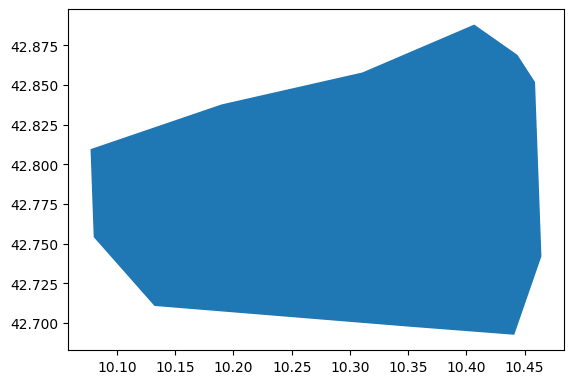

In [155]:
area_around_elba.plot()
plt.show()

In [157]:
gdf_clipped_area = gpd.clip(macroregions24.to_crs(epsg=4326), area_around_elba, keep_geom_type=False)


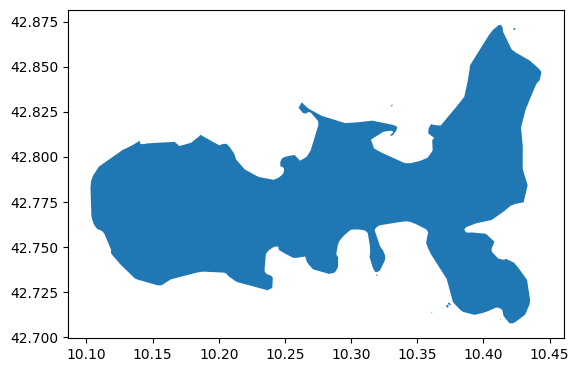

In [158]:
gdf_clipped_area.plot()
plt.show()

In [159]:
elba_island = gdf_clipped_area.dissolve()

In [160]:
elba_island

,geometry,COD_RIP,DEN_RIP
0,"MULTIPOLYGON (((10.36097 42.71333, 10.36101 42...",3,Centro


remove not usefull columns

In [161]:
del elba_island['COD_RIP']

In [162]:
del elba_island['DEN_RIP']

In [163]:
elba_island['name'] = "Elba"

In [164]:
elba_island

,geometry,name
0,"MULTIPOLYGON (((10.36097 42.71333, 10.36101 42...",Elba


if you want to know the names of the municipalities on the Island of Elba

In [165]:
municipalities_in_elba = municipalities24[municipalities24.to_crs(epsg=4326).geometry.intersects(elba_island.geometry.values[0]) == True]
%time

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs


In [166]:
municipalities_in_elba

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,geometry
4395,3,9,49,0,49,49003,049003,Campo nell'Elba,0,0,"MULTIPOLYGON (((590833.849 4715112.607, 590819..."
4396,3,9,49,0,49,49004,049004,Capoliveri,0,0,"MULTIPOLYGON (((615720.291 4729535.284, 615714..."
4402,3,9,49,0,49,49010,049010,Marciana,0,0,"MULTIPOLYGON (((593200.086 4740268.898, 593249..."
4403,3,9,49,0,49,49011,049011,Marciana Marina,0,0,"MULTIPOLYGON (((596965.742 4740646.29, 597641...."
4405,3,9,49,0,49,49013,049013,Porto Azzurro,0,0,"MULTIPOLYGON (((614188.616 4738752.172, 614818..."
4406,3,9,49,0,49,49014,049014,Portoferraio,0,0,"MULTIPOLYGON (((608232.086 4689573.499, 609309..."
4411,3,9,49,0,49,49021,049021,Rio,0,0,"MULTIPOLYGON (((626486.815 4746023.841, 626396..."


or

In [167]:
municipalities_in_elba = gpd.clip(municipalities24.to_crs(epsg=4326), area_around_elba, keep_geom_type=False)
%time

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [168]:
municipalities_in_elba

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,geometry
4406,3,9,49,0,49,49014,049014,Portoferraio,0,0,"MULTIPOLYGON (((10.33035 42.82805, 10.33007 42..."
4395,3,9,49,0,49,49003,049003,Campo nell'Elba,0,0,"POLYGON ((10.23976 42.77261, 10.2411 42.77261,..."
4402,3,9,49,0,49,49010,049010,Marciana,0,0,"POLYGON ((10.14049 42.80775, 10.14061 42.80756..."
4403,3,9,49,0,49,49011,049011,Marciana Marina,0,0,"POLYGON ((10.19423 42.80887, 10.20075 42.8063,..."
4396,3,9,49,0,49,49004,049004,Capoliveri,0,0,"MULTIPOLYGON (((10.41301 42.7096, 10.41295 42...."
4405,3,9,49,0,49,49013,049013,Porto Azzurro,0,0,"POLYGON ((10.40395 42.7925, 10.40462 42.79244,..."
4411,3,9,49,0,49,49021,049021,Rio,0,0,"MULTIPOLYGON (((10.42397 42.87046, 10.42292 42..."


PS:

If someone tells you that there are 7 municipalities in Elba, tell them they are wrong:
The Municipality of Rio was established in *2018* following the merger of the municipalities of Rio d'Elba, Rio Marina and others.

[https://en.wikipedia.org/wiki/Rio,_Italy](https://en.wikipedia.org/wiki/Rio,_Italy)

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/rio_wikipedia.png)

# The use of the Spatial SQL

![](https://raw.githubusercontent.com/napo/geospatial_datascience_unitn_2023/main/images/introduckdb.png)<br/>
![](https://raw.githubusercontent.com/napo/geospatial_datascience_unitn_2023/main/images/whyduckdb.png)

load dataset from http<br/>
[https://duckdb.org/docs/archive/0.9.0/guides/import/http_import](https://duckdb.org/docs/archive/0.9.0/guides/import/http_import)

```sql
napo@datascience:~$ duckdb
v1.1.1 af39bd0dcf
Enter ".help" for usage hints.
Connected to a transient in-memory database.
Use ".open FILENAME" to reopen on a persistent database.
D install httpfs;
D load https;
D
```

we have the (geo)parquet file here -https://raw.githubusercontent.com/napo/geospatial_unitn_2024/refs/heads/main/data/municipalities_piedmont_2024.parquet

We can reach with this syntax
```sql
SELECT * FROM read_parquet('https://raw.githubusercontent.com/napo/geospatial_unitn_2024/refs/heads/main/data/municipalities_piedmont_2024.parquet') limit 3
```

but before we have to install httpfs module and load it

```sql
D INSTALL httpfs;
D LOAD httpfs;
```

```sql
D SELECT * FROM read_parquet('https://raw.githubusercontent.com/napo/geospatial_unitn_2024/refs/heads/main/data/municipalities_piedmont_2024.parquet');
┌┌─────────┬─────────┬──────────┬───┬──────────┬────────┬──────────────────────┐
│ COD_RIP │ COD_REG │ COD_PROV │ … │ COMUNE_A │ CC_UTS │       geometry       │
│  int64  │  int64  │  int64   │   │ varchar  │ int64  │       geometry       │
├─────────┼─────────┼──────────┼───┼──────────┼────────┼──────────────────────┤
│       1 │       1 │        1 │ … │ 0        │      0 │ POLYGON ((7.782661…  │
│       1 │       1 │        1 │ … │ 0        │      0 │ POLYGON ((7.487945…  │
│       1 │       1 │        1 │ … │ 0        │      0 │ POLYGON ((7.273242…  │
│       1 │       1 │        1 │ … │ 0        │      0 │ POLYGON ((7.925073…  │
│       1 │       1 │        1 │ … │ 0        │      0 │ POLYGON ((7.434894…  │
│       1 │       1 │        1 │ … │ 0        │      0 │ POLYGON ((7.579870…  │
│       · │       · │        · │ · │ ·        │      · │          ·           │
│       · │       · │        · │ · │ ·        │      · │          ·           │
│       · │       · │        · │ · │ ·        │      · │          ·           │
│       1 │       1 │      103 │ … │ 0        │      0 │ POLYGON ((8.274228…  │
│       1 │       1 │      103 │ … │ 0        │      0 │ POLYGON ((8.164370…  │
│       1 │       1 │      103 │ … │ 0        │      0 │ POLYGON ((8.611714…  │
├─────────┴─────────┴──────────┴───┴──────────┴────────┴──────────────────────┤
│ 1180 rows (40 shown)                                   11 columns (6 shown) │
└─────────────────────────────────────────────────────────────────────────────┘


D

```

```sql
D DESCRIBE (select * FROM read_parquet('https://raw.githubusercontent.com/napo/geospatial_unitn_2024/refs/heads/main/data/municipalities_piedmont_2024.parquet'));
┌─────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│ column_name │ column_type │  null   │   key   │ default │  extra  │
│   varchar   │   varchar   │ varchar │ varchar │ varchar │ varchar │
├─────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ COD_RIP     │ BIGINT      │ YES     │         │         │         │
│ COD_REG     │ BIGINT      │ YES     │         │         │         │
│ COD_PROV    │ BIGINT      │ YES     │         │         │         │
│ COD_CM      │ BIGINT      │ YES     │         │         │         │
│ COD_UTS     │ BIGINT      │ YES     │         │         │         │
│ PRO_COM     │ BIGINT      │ YES     │         │         │         │
│ PRO_COM_T   │ VARCHAR     │ YES     │         │         │         │
│ COMUNE      │ VARCHAR     │ YES     │         │         │         │
│ COMUNE_A    │ VARCHAR     │ YES     │         │         │         │
│ CC_UTS      │ BIGINT      │ YES     │         │         │         │
│ geometry    │ GEOMETRY    │ YES     │         │         │         │
├─────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┤
│ 11 rows                                                 6 columns │
└───────────────────────────────────────────────────────────────────┘


```

and now we can extend to the use of the spatial sql



# The use of the Spatial SQL

![](https://raw.githubusercontent.com/napo/geospatial_unitn_2024/refs/heads/main/images/duckdbspatial.png)

more info [https://duckdb.org/docs/extensions/spatial](https://duckdb.org/docs/extensions/spatial)

```sql
D INSTALL spatial;
D LOAD spatial;
```

Special thanks to [aborruso](https://github.com/aborruso)


 ```sql
select geometry FROM read_parquet('https://raw.githubusercontent.com/napo/geospatial_unitn_2024/refs/heads/main/data/municipalities_piedmont_2024.parquet') limit 3;

┌──────────────────────────────────────────────────────────────────────────────┐
│                                   geometry                                   │
│                                   geometry                                   │
├──────────────────────────────────────────────────────────────────────────────┤
│ POLYGON ((7.782661552135448 45.387173503716724, 7.783045473409182 45.38714…  │
│ POLYGON ((7.487945585386852 44.93917423530563, 7.487978813605857 44.938738…  │
│ POLYGON ((7.273242274516022 45.339272571635036, 7.273440161433753 45.33906…  │
└──────────────────────────────────────────────────────────────────────────────┘

D
``````

```sql
select COMUNE, geometry FROM read_parquet('https://raw.githubusercontent.com/napo/geospatial_unitn_2024/refs/heads/main/data/municipalities_piedmont_2024.parquet') where COMUNE='Torino';
```

```sql
┌─────────┬────────────────────────────────────────────────────────────────────┐
│ COMUNE  │                              geometry                              │
│ varchar │                              geometry                              │
├─────────┼────────────────────────────────────────────────────────────────────┤
│ Torino  │ MULTIPOLYGON (((7.747047140657367 45.12389059376807, 7.747116510…  │
└─────────┴────────────────────────────────────────────────────────────────────┘

```

```sql
select COMUNE as city, ST_Area(geometry) FROM read_parquet('https://raw.githubusercontent.com/napo/geospatial_unitn_2024/refs/heads/main/data/municipalities_piedmont_2024.parquet') where COMUNE='Torino';


```

```sql
┌─────────┬──────────────────────┐
│  city   │  st_area(geometry)   │
│ varchar │        double        │
├─────────┼──────────────────────┤
│ Torino  │ 0.014862288347664709 │
└─────────┴──────────────────────┘

```

```sql
select COMUNE as city, ST_Area(ST_TRANSFORM(geometry,'EPSG:4326','EPSG:32632')) as areamq FROM read_parquet('https://raw.githubusercontent.com/napo/geospatial_unitn_2024/refs/heads/main/data/municipalities_piedmont_2024.parquet') where COMUNE='Torino';


```

```sql
┌─────────┬───────────────────┐
│  city   │      areamq       │
│ varchar │      double       │
├─────────┼───────────────────┤
│ Torino  │ 275675106.0864546 │
└─────────┴───────────────────┘

```

In [169]:
geo_libraries.to_file("italian_libraries.geojson")

note: run duckdb from the same directory where you stored the file italian_libraries.geojson

```sql
D DESCRIBE (SELECT * FROM ST_Read('italian_libraries.geojson'));
┌────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│  column_name   │ column_type │  null   │   key   │ default │  extra  │
│    varchar     │   varchar   │ varchar │ varchar │ varchar │ varchar │
├────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ isil           │ VARCHAR     │ YES     │         │         │         │
│ sbn            │ VARCHAR     │ YES     │         │         │         │
│ name           │ VARCHAR     │ YES     │         │         │         │
│ address        │ VARCHAR     │ YES     │         │         │         │
│ village        │ VARCHAR     │ YES     │         │         │         │
│ zipcode        │ INTEGER     │ YES     │         │         │         │
│ city           │ VARCHAR     │ YES     │         │         │         │
│ istat_city     │ INTEGER     │ YES     │         │         │         │
│ province       │ VARCHAR     │ YES     │         │         │         │
│ region         │ VARCHAR     │ YES     │         │         │         │
│ istat_province │ INTEGER     │ YES     │         │         │         │
│ latitude       │ DOUBLE      │ YES     │         │         │         │
│ longitude      │ DOUBLE      │ YES     │         │         │         │
│ phone          │ VARCHAR     │ YES     │         │         │         │
│ fax            │ VARCHAR     │ YES     │         │         │         │
│ email          │ VARCHAR     │ YES     │         │         │         │
│ url            │ VARCHAR     │ YES     │         │         │         │
│ geom           │ GEOMETRY    │ YES     │         │         │         │
├────────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┤
│ 18 rows                                                    6 columns │
└──────────────────────────────────────────────────────────────────────┘
```

```sql
CREATE TABLE municipalities AS
    SELECT COMUNE AS city, geometry AS geometry
    FROM read_parquet('https://raw.githubusercontent.com/napo/geospatial_unitn_2024/refs/heads/main/data/municipalities_piedmont_2024.parquet');
````

```sql
CREATE TABLE libraries as
SELECT
    name,
    address,
    city,
    libraries.geom as geometry,
    FROM ST_Read('italian_libraries.geojson') as libraries;
```


```sql
SELECT libraries.name, libraries.city as city_library,
    municipalities.city as city_municipality
    FROM libraries, municipalities
    WHERE ST_WITHIN(libraries.geometry, municipalities.geometry);
``````

```sql
┌────────────────────────────────┬──────────────────────┬──────────────────────┐
│              name              │     city_library     │  city_municipality   │
│            varchar             │       varchar        │       varchar        │
├────────────────────────────────┼──────────────────────┼──────────────────────┤
│ BIBLIOTECA CIVICA DI BARDONE…  │ Bardonecchia         │ Bardonecchia         │
│ Biblioteca pubblica 2 giugno   │ Cesana Torinese      │ Cesana Torinese      │
│ Biblioteca civica              │ Oulx                 │ Oulx                 │
│ Biblioteca civica "Teresa Ra…  │ Sauze d'Oulx         │ Sauze d'Oulx         │
│ Biblioteca comunale di Sestr…  │ Sestriere            │ Sestriere            │
│ Biblioteca civica              │ Salbertrand          │ Salbertrand          │
│ Biblioteca del Parco natural…  │ Salbertrand          │ Salbertrand          │
│ Biblioteca del Parco natural…  │ Pragelato            │ Pragelato            │
│ Biblioteca civica - Fondazio…  │ Pragelato            │ Pragelato            │
│ Biblioteca Comunale            │ Chiomonte            │ Chiomonte            │
│ Biblioteca civica              │ Moncenisio           │ Moncenisio           │
│ Biblioteca dell'Abbazia dei …  │ Novalesa             │ Novalesa             │
│ Biblioteca comunale            │ Venaus               │ Venaus               │
│ Biblioteca comunale            │ Giaglione            │ Giaglione            │
│ Biblioteca civica              │ Novalesa             │ Novalesa             │
│ Biblioteca comunale di Usseaux │ Usseaux              │ Usseaux              │
│ Biblioteca del Liceo classic…  │ Susa                 │ Susa                 │
│ Biblioteca scolastica dell'I…  │ Susa                 │ Susa                 │
│ Biblioteca dell'Istituto Suo…  │ Susa                 │ Susa                 │
│ Biblioteca diocesana di Susa   │ Susa                 │ Susa                 │
│              ·                 │  ·                   │  ·                   │
│              ·                 │  ·                   │  ·                   │
│              ·                 │  ·                   │  ·                   │
│ Biblioteca della Fondazione …  │ Tortona              │ Tortona              │
│ Biblioteca del Liceo Giusepp…  │ Tortona              │ Tortona              │
│ Biblioteca diocesana del Sem…  │ Tortona              │ Tortona              │
│ Biblioteca civica              │ Stazzano             │ Stazzano             │
│ Biblioteca civica "Tommaso d…  │ Tortona              │ Tortona              │
│ Biblioteca del Convento dei …  │ Tortona              │ Tortona              │
│ Biblioteca comunale Pier Ang…  │ Castelnuovo Scrivia  │ Castelnuovo Scrivia  │
│ Biblioteca civica "Gaetano P…  │ Arquata Scrivia      │ Arquata Scrivia      │
│ Biblioteca civica              │ Vignole Borbera      │ Vignole Borbera      │
│ Biblioteca civica              │ Sardigliano          │ Sardigliano          │
│ Biblioteca civica di Viguzzolo │ Viguzzolo            │ Viguzzolo            │
│ Biblioteca civica Sandro Cas…  │ Pontecurone          │ Pontecurone          │
│ Biblioteca civica              │ Borghetto di Borbera │ Borghetto di Borbera │
│ Biblioteca dell'Associazione…  │ Volpedo              │ Volpedo              │
│ Biblioteca comunale "Mario F…  │ Volpedo              │ Volpedo              │
│ Biblioteca comunale di Casal…  │ Casalnoceto          │ Casalnoceto          │
│ BIBLIOTECA CIVICA GIORGIO BO…  │ Albera Ligure        │ Albera Ligure        │
│ Biblioteca civica "Scarsi Ce…  │ Cabella Ligure       │ Cabella Ligure       │
│ Biblioteca comunale di Gremi…  │ Gremiasco            │ Gremiasco            │
│ Biblioteca Comunale "Elvezia…  │ Carrega Ligure       │ Carrega Ligure       │
├────────────────────────────────┴──────────────────────┴──────────────────────┤
│ 1202 rows (40 shown)                                               3 columns │
└──────────────────────────────────────────────────────────────────────────────┘
``````



```sql
SELECT count(*)
    FROM libraries, municipalities
    WHERE ST_WITHIN(libraries.geometry, municipalities.geometry);
```

```sql
┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│         1202 │
└──────────────┘

```

Export in geojson format
```sql
COPY (
    SELECT libraries.name, libraries.city as city_library,
        municipalities.city as city_municipality, libraries.geometry
        FROM libraries, municipalities
     WHERE ST_WITHIN(libraries.geometry, municipalities.geometry)
) TO 'libraries_piedemont.geojson'
WITH (FORMAT GDAL, DRIVER 'GeoJSON');
```

In [171]:
gpd.read_file("libraries_piedemont.geojson").explore()